# Explainable AI in Finance: Fundamental Factor Modeling

This notebook explores how Explainable AI (XAI) techniques can be applied to machine-learning models commonly used in fundamental factor investing.

We use a toy dataset containing 6 fundamental BARRA-style factors for 218 stocks across 100 months, starting in February 2008. The objective is to predict each stock's monthly excess return based on its factor exposures. The data has already been rescaled. 

We train an `XGBRegressor` model, a gradient boosting model based on decision trees, implemented in the XGBoost library. It builds an ensemble of shallow trees, where each new tree corrects the errors of the previous ones, enabling highly accurate regression on tabular data.

We first build a base model with a random selection of hyperparameters, before using cross-validation to perform hyperparameter tuning. We evaluate the final model using a held-out test data.

To interpret model predictions, we demonstrate several post-hoc explainability techniques discussed in the [Explainable AI in Finance](url), including:

* Feature importance plots: A feature relevance approach used to provide scores indicating how useful or valuable each feature was in the construction of the boosted decision trees within the model.

* SHAP (SHapley Additive exPlanations): A feature attribution method that quantifies the contribution of each input feature to an individual prediction.

* LIME (Local Interpretable Model-agnostic Explanations): A simplification method that builds locally linear models to approximate black-box predictions.

* Partial Dependence Plots: Visual methods showing how changes in one feature affect predictions, whilst keeping all other features constant. Averaged across an entire dataset of samples.
  
* Individual Conditional Expectation Plots: Identical to Partial Dependence Plots but plot on a per-sample basis instead of an aggregated average. 

In [1]:
# Load libraries
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
import shap
import lime
import lime.lime_tabular
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


/opt/anaconda3/envs/XAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and view the data

In [2]:
data = pd.read_csv('data/data.csv')
data.head()

,EV,P/B,EV/T12M EBITDA,P/S,P/E,Log CAP,date,monthly_return
0,-0.631674,-0.336891,-0.476277,-0.722528,-0.225914,-2.868252,2/1/08,0.034761
1,-0.357068,-0.065023,-0.055783,0.570305,-0.056345,0.246958,2/1/08,0.229210
2,6.131448,-0.031665,-0.222194,-0.365276,-0.123514,1.270398,2/1/08,-0.046086
3,-0.631674,-0.336891,-0.476277,-0.722528,-0.225914,-2.868252,2/1/08,0.034761
4,-0.300785,-0.189143,0.222278,-0.346733,0.422348,0.172286,2/1/08,0.006658


# Divide into training and test datasets 

In [3]:
# Divide into X and Y data 
features = ['EV', 'P/B', 'EV/T12M EBITDA', 'P/S', 'P/E', 'Log CAP']
X = data[features]
Y = data['monthly_return']
# Split into 80/20 test split - shuffle = False to keep temporal ordering
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False) 

# Base model - no tuning

In [4]:
# Base model (no hyperparameter tuning)
base_model = XGBRegressor(n_estimators=500, max_depth=3)
# Set-up 5-fold time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
# Fit the model for each fold and calculate average MSE
scores = cross_val_score(base_model, X_train, Y_train, cv=tscv, scoring='neg_root_mean_squared_error')
print("Cross-validated RMSE: ", -scores.mean())


Cross-validated RMSE:  0.10202336138820955


# Hyperparameter tuning

In [5]:
# Instantiate model 
model = XGBRegressor()
# Define grid of hyperparameter values to search 
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'max_depth': [3, 4, 5,6,7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
    }
# Perform time-series cross-validation with each combination of hyperparameter values to find the optimal model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1,verbose=True)
grid_search.fit(X_train, Y_train)

# Save the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print results
print("Best parameters:", best_params)
print(f"Best model RMSE: {-grid_search.best_score_}")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best model RMSE: 0.08861601338597971


We see that by tuning the hyperparameters of the model, we have been able to reduce the RMSE from 0.102 to 0.089.

In [6]:
# Predict test set using best model
Y_pred = best_model.predict(X_test)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print("Test RMSE: ", rmse)

Test RMSE:  0.07453958919463852


# Explainability plots

## Feature importance 

Feature importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more a feature is used to make key decisions with decision trees, the higher its relative importance. This importance is calculated explicitly for each feature in the dataset, allowing features to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each feature split point improves the performance measure, weighted by the number of observations the node is responsible for. The feature importances are then averaged across all of the  decision trees within the model.

There are three common importance measures already incorporated in XGBoost library, `weight`, `cover` and `gain`. Weight refers to the number of times a feature is used to split the data across all trees, offering a sense of frequency but not necessarily usefulness. Cover measures the average number of samples affected by those splits, reflecting how broadly a feature influences the dataset. Gain captures the average improvement in the model’s loss function (like log-loss or MSE) from using a feature in a split, making it the most meaningful metric for understanding a feature’s actual contribution to predictive performance.

Below we will plot all three performance metrics of the best-performing model for a comprehensive overview.

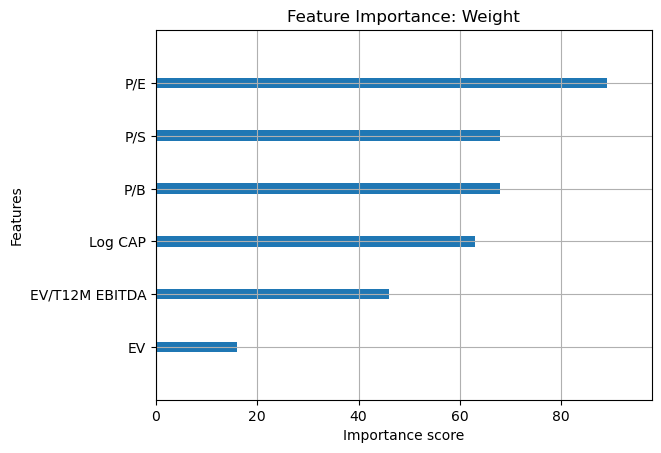

In [7]:
# plot feature importance for differnet importance types
plot_importance(best_model,importance_type='weight',show_values=False)
plt.title('Feature Importance: Weight')
plt.show()

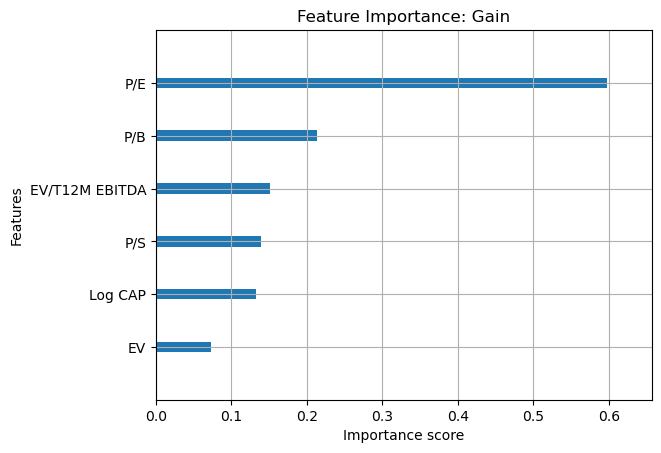

In [8]:
plot_importance(best_model,importance_type='gain',show_values=False)
plt.title('Feature Importance: Gain')
plt.show()

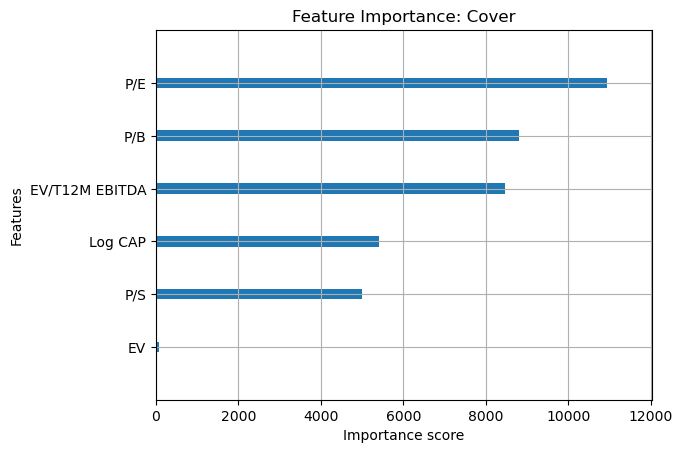

In [9]:
plot_importance(best_model,importance_type='cover',show_values=False)
plt.title('Feature Importance: Cover')
plt.show()

We see different results based on the feature importance metric used, though `P/E` has the highest importance score for each metric. However, these plots don't tell us anything about what impact each variable has on the monthly log returns.

## Shapley values

SHAP values show us a local view of the effect of each feature on the prediction for each sample. They can be calculated on training data without violating the explanation’s integrity, unlike performance metrics. This is because SHAP’s goal is not to evaluate generalization but to attribute model predictions to input features, and the model behaves similarly across splits. In tutorials, you will see individuals use `X_train`, `X_test` and `X` to calculate Shapley values. All methods should return similar results so long as the splits are similar. In our example, we will use the entire dataset, `X` to calculate the values. Using more instances means you get a more faithful average picture of the model’s behavior. The model has been trained on the training data, but it will perform similarly across all instances of the data, so more data is better.

SHAP (SHapley Additive exPlanations) values provide a local view of how each feature contributes to a model’s prediction for each individual instance. Since SHAP does not retrain or alter the model, and because it attributes predictions rather than evaluating accuracy, it is perfectly valid to compute SHAP values on the training data. The model’s behavior — that is, how it transforms inputs into predictions — is typically consistent across data splits, provided the data splits are similar.

This is why you’ll often see tutorials using `X_train`, `X_test`, or even the full dataset when calculating SHAP values. All of these will typically yield similar SHAP explanations.

In our case, we’ll use the entire dataset, X, to calculate SHAP values, which allows us to include more examples and thus obtain a richer, more representative picture of the model’s behavior across the dataset. While the model was trained only on the training set, its decision logic applies broadly across all instances — so using more data provides a richer insight.



In [10]:
# Indicate which features are most important using SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X) 

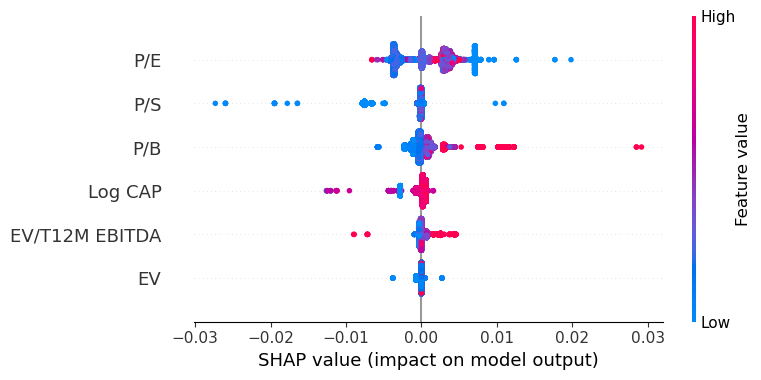

In [11]:
# Plot results
shap.summary_plot(shap_values, X)

Each point on the SHAP summary plot represents a single prediction for a single data point, showing how much a specific feature contributed to that prediction — both in magnitude and direction. For example, we see that high values in the P/B ratio typically led to increased monthly return predictions. 

## LIME

Local Interpretable Model-agnostic Explanations or LIME for short, provides an explanation for individual predictions. It explains the prediction of a 'black-box' model by approximating it locally with an interpretable model like linear regression or decision trees. The way LIME works is conceptually simple. For an individual sample, LIME creates perturbed samples around the sample being explained by slightly altering the input data. These perturbed samples are then fed into the complex model to obtain predictions. A simple, interpretable model such as a linear regression is then fitted to the predictions of the complex model in the local region around the instance. The weights of the local model indicate the importance of each feature in the decision-making process for that specific instance.

In [12]:
#  Build a LIME explainer for our model
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=features,
    mode='regression',
    verbose=True,
    random_state=42
)

In [13]:
# Take first test sample and explain it using LIME explainer
exp = explainer.explain_instance(X_test.values[0], best_model.predict,num_features=len(features))

Intercept 0.002994587462748124
Prediction_local [0.00614553]
Right: 0.0056087472


In [17]:
print(exp.show_in_notebook(show_table=True))

None


The result contains three main pieces of information from left to right: (1) the model’s predicted value, (2) the contributions of each feature, and (3) the actual value for each feature for that test sample. 

We see the predicted monthly return for the first test value is 0.01 (left). We see that there are 4 features positively contributing to this prediction - the Log CAP value is > 0.42, the EV is > -0.05, the P/S is greater than -0.56 but less than or equal to -0.32, and the P/E ratio is between -0.14 and -0.09. The right hand plot shows the real feature values for this test sample.


## Partial dependence plots

Partial dependence plots (PDP) show us how changing the value of one feature impacts the predictions of the model, whilst holding all other features constant. Let's plot the PDP for each feature using on our test dataset and compare the results to the SHAP summary plot.

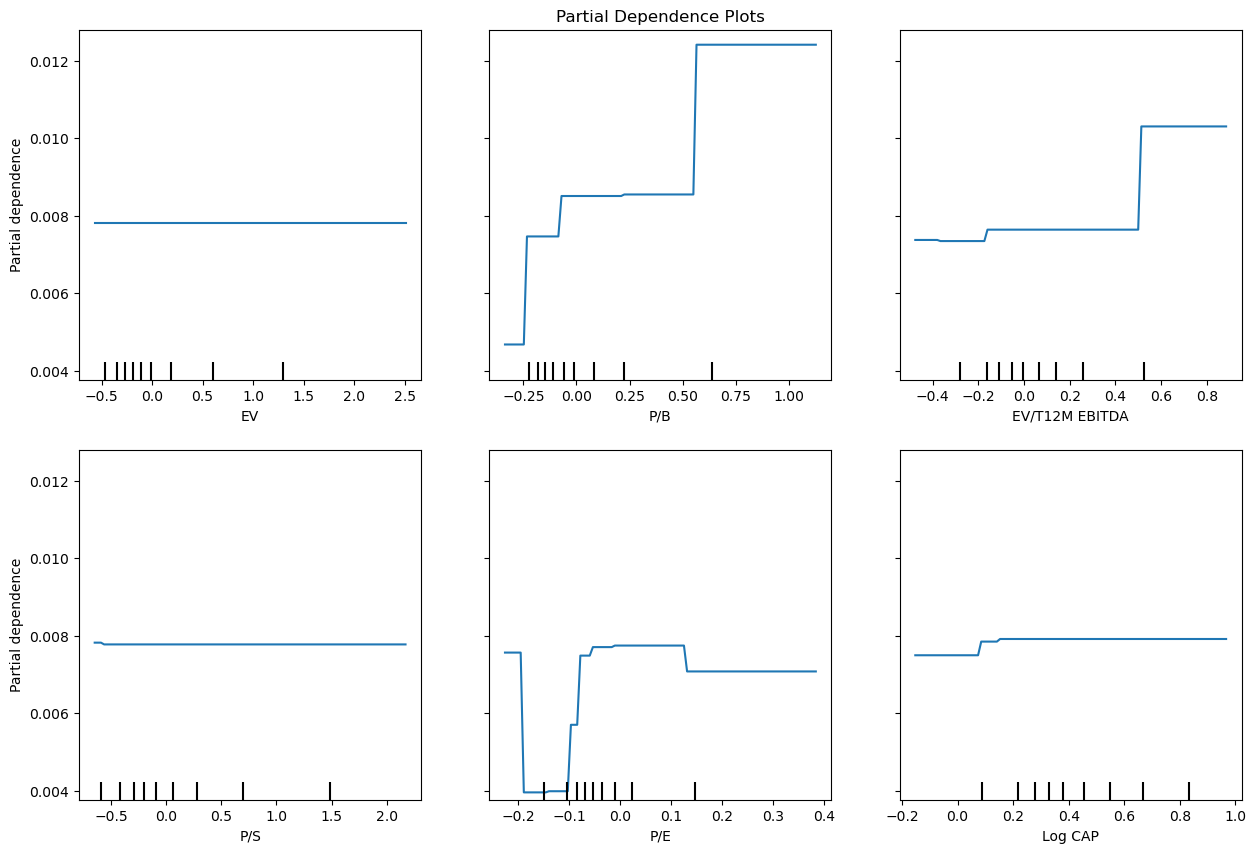

In [15]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Partial Dependence Plots")
PartialDependenceDisplay.from_estimator(
    estimator=best_model,
    X=X_test,
    features=features,
    random_state=42,
    ax=ax,kind='average'
)
plt.show()

We see that  and P/S and EV features aren't used in prediction at all - this is shown by the horizontal line, changing the value of these features does not impact the predictions of the model. In contrast, we see the largest step changes in the P/B feature, where we see increasing P/B leads to increased predictions. We also see that for the P/E ratio, negative values correspond to lower returns. Both of these observations are similar to what we saw with the SHAP summary plot, however we can more clearly see the 'cut-off' values for each feature where predictions change. For example, for the P/E ratio PDP, we see a slight drop in predicted monthly returns when the stock's scaled P/E ratio is above ~0.15. Note that each plot shows the global impact of the feature on predictions - it does not show what effect each feature has on individual predictions - which is what SHAP does.

## Individual Conditional Expectation (ICE) plots

The PDP function can also output ICE plots, to do that we simply change the `kind` argument to `individual` to see the impact of each feature on individual predictions.  We now plot the results for each data point instead of taking the average. 

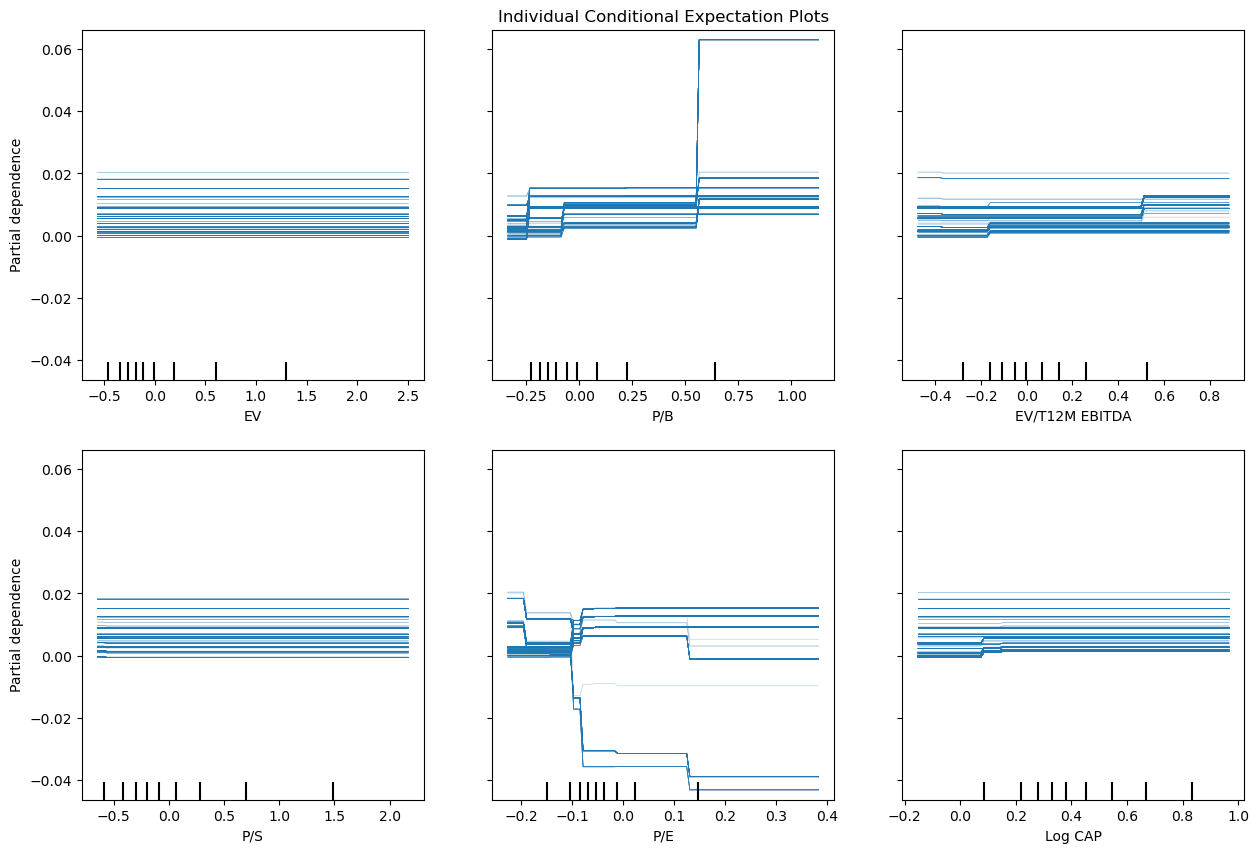

In [16]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Individual Conditional Expectation Plots")
PartialDependenceDisplay.from_estimator(
    estimator=best_model,
    X=X_test,
    features=features,
    random_state=42,
    ax=ax,kind='individual'
)
plt.show()

We can now see how modifying the value of one feature impacts the predicted monthly return for each individual data point.

# Summary

Each explainability method offers unique insight into the 'black-box' nature of the XGBRegressor model, offering a more transparent view behind its predictions. Together, these XAI methods form a toolkit for interpreting such models in financial contexts - enabling practitioners to validate model behavior, ensure regulatory compliance, and build trust with stakeholders. While no single method offers a complete explanation, their combination helps bridge the gap between predictive performance and interpretability.